<a href="https://colab.research.google.com/github/freha-mezzoudj/NLP_airline_tweets/blob/main/Copie_de_Airlines_Tweet_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd # Linear Algebra
from pandas import read_excel # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
#!pip install re
!pip install unidecode
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D

from tensorflow.keras.optimizers import SGD,Adam

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

from warnings import filterwarnings


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.3 MB/s 


In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/data")

In [ ]:
df=pd.read_csv('Tweets2.csv')
df = df[["airline_sentiment","text"]]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [ ]:
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="neutral", value=2)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="positive", value=1)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="negative", value=0)
df


,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...
14637,2,@AmericanAir Please bring American Airlines to...
14638,0,"@AmericanAir you have my money, you change my ..."


In [ ]:
#Number of sentiments in each category

df.airline_sentiment.value_counts()

0    9178
2    3099
1    2363
Name: airline_sentiment, dtype: int64

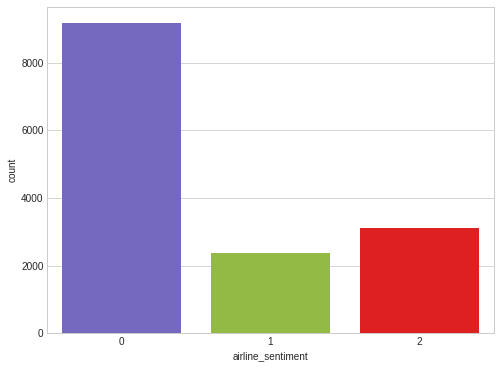

In [ ]:
# Unique values of sentiment plot

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6))
col = ['slateblue', 'yellowgreen', 'red']
ax = sns.countplot(x="airline_sentiment", data=df, palette = col)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


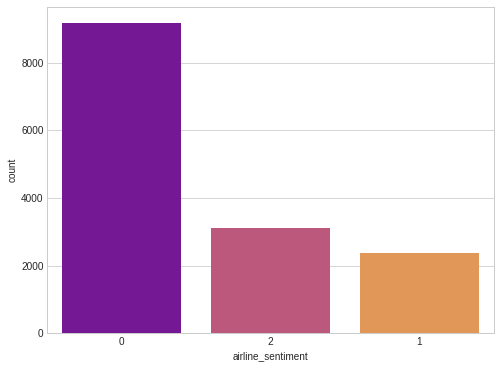

In [ ]:
#2nd alternative barplot
plt.figure(figsize=(8,6))
sns.countplot(df['airline_sentiment'], order =df.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

**Standard Text Pre-Processing**

Text preprocessing steps include tasks like:-

1. **Stop-Word Removal** : In English words like a, an, the, as, in, on, etc. are considered as stop-words that we can remove them to reduce vocabulary size (these words don't have some specific meaning).

2. **Lower Casing** : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. (which reduce the vocabulary size:  The and the are the same!) 

3. **Stemming texte en gras** : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “do” and “doing” are both reduced to “do”).

4. **Tokenization** : NLP software typically analyzes text by breaking it up into tokens (which can words or sentences).

**Cleaning Data (2)**

In [ ]:
df2 = df.copy()

In [ ]:
df2

,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...
14637,2,@AmericanAir Please bring American Airlines to...
14638,0,"@AmericanAir you have my money, you change my ..."


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
#print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
def clean_text(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]

    
    #joining
    return " ".join(text_cleaned)

In [ ]:
cleaned_txt = df2["text"].apply(clean_text)
cleaned_txt.head()

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

**Build Machine Learning Model**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df2['text']
y = df2['airline_sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['text'] = X_train
df_train['airline_sentiment'] = y_train
df_train = df_train.reset_index(drop=True)

df_test['text'] = X_test
df_test['airline_sentiment'] = y_test
df_test = df_test.reset_index(drop=True)

In [ ]:
class TweetNBClassifier(object):

    def __init__(self, df_train):
        self.df_train = df_train
        self.df_pos = df_train.copy()[df_train.airline_sentiment == 'positive']
        self.df_neg = df_train.copy()[df_train.airline_sentiment == 'negative']
        self.df_neu = df_train.copy()[df_train.airline_sentiment == 'neutral']

    def fit(self):
        Pr_pos = df_pos.shape[0]/self.df_train.shape[0]
        Pr_neg = df_neg.shape[0]/self.df_train.shape[0]
        Pr_neu = df_neu.shape[0]/self.df_train.shape[0]
        self.Prior  = (Pr_pos, Pr_neg, Pr_neu)

        self.pos_words = ' '.join(self.df_pos['text'].tolist()).split()
        self.neg_words = ' '.join(self.df_neg['text'].tolist()).split()
        self.neu_words = ' '.join(self.df_neu['text'].tolist()).split()

        all_words = ' '.join(self.df_train['text'].tolist()).split()

        self.vocab = len(Counter(all_words))

        wc_pos = len(' '.join(self.df_pos['text'].tolist()).split())
        wc_neg = len(' '.join(self.df_neg['text'].tolist()).split())
        wc_neu = len(' '.join(self.df_neu['text'].tolist()).split())
        self.word_count = (wc_pos, wc_neg, wc_neu)
        return self

    def predict(self, df_test):
        class_choice = ['positive', 'negative', 'neutral']

        classification = []
        for tweet in df_test['text']:
            text = tweet.split()

            val_pos = np.array([])
            val_neg = np.array([])
            val_neu = np.array([])
            for word in text:
                tmp_pos = np.log(self.pos_words.count(word)+1)
                tmp_neg = np.log(self.neg_words.count(word)+1)
                tmp_neu = np.log(self.neu_words.count(word)+1)
                val_pos = np.append(val_pos, tmp_pos)
                val_neg = np.append(val_neg, tmp_neg)
                val_neu = np.append(val_neu, tmp_neu)

            denom_pos = len(text)*np.log(self.word_count[0]+self.vocab)
            denom_neg = len(text)*np.log(self.word_count[1]+self.vocab)
            denom_neu = len(text)*np.log(self.word_count[2]+self.vocab)

            val_pos = np.log(self.Prior[0]) + np.sum(val_pos) - denom_pos
            val_neg = np.log(self.Prior[1]) + np.sum(val_neg) - denom_neg
            val_neu = np.log(self.Prior[2]) + np.sum(val_neu) - denom_neu

            probability = (val_pos, val_neg, val_neu)
            classification.append(class_choice[np.argmax(probability)])
        return classification

    def score(self, feature, target):
        comp_c, comp_i = (0,0)
        tp, tn, fp, fn = (0,0,0,0)
        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                comp_c += 1
                if (target[i] == 'positive') & (feature[i] == 'positive'): tp += 1
            else:
                comp_i += 1
                if (target[i] == 'positive') & (feature[i] == 'negative'): fn += 1
                if (target[i] == 'negative') & (feature[i] == 'positive'): fp += 1

        accuracy  = comp_c/(comp_c + comp_i)
        precision = tp/(tp + fp)
        recall    = tp/(tp + fn)
        return accuracy, precision, recall
        

In [ ]:
tnb = TweetNBClassifier(df_train)

In [ ]:
tnb = tnb.fit()
predict = tnb.predict(df_test)
score = tnb.score(predict, df_test.airline_sentiment.tolist())

In [ ]:
cm = confusion_matrix(df_test['airline_sentiment'], predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# **Archive**

**Fonctions can be used to clean the text!**

**Cleaning Data (0)** 


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

**Cleaning Data (1)**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Removing @ which mostly refers to the airline and does not add information
text = [re.sub(r"@(\S*)",r"",text) for text in df['text'].astype('str')]

In [ ]:
text[0:5]

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it"]

Removing URLs

In [ ]:
text = [re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",t) for t in text]

In [ ]:
text[0:5]

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it"]

Recognize Emoticons and transform them into text. For inscante turn :) into '**Happy**'.

In [ ]:
#happyness
text = [re.sub(r':\)|:-\)|:D|;\)|;-\)|:-D',"HAPPY",t) for t in text]
#sadness
text = [re.sub(r':\(|:-\(|;\(|;-\(',"SAD",t) for t in text]

In [ ]:
text[0:5]

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it"]

In [ ]:
import unicodedata
#text = [re.sub('u[\U0001F602-\U0001F64F]', lambda m: unicodedata.name(m.group()), t,flags=re.UNICODE) for t in text]

In [ ]:
text = [re.sub("[^a-zA-Z]"," ",t).lower() for t in text]

In [ ]:
text = pd.Series(text)

**Thanks!**